# Task 1: Binary Image Classification - Cats vs Dogs

## MLOps Assignment - Image Preprocessing & Data Augmentation

**Goal**: Implement image preprocessing pipeline with data augmentation for binary image classification
- Dataset: Cats vs Dogs from Kaggle (PetImages)
- Image preprocessing: 224x224 RGB normalized to [0,1]
- Data augmentation: 5 techniques with 2x multiplier
- Data splitting: 80% train, 10% validation, 10% test (stratified)
- Model: Simple CNN for binary classification

## 1. Import Required Libraries

In [17]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image, ImageEnhance, ImageOps
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Add path to import from cats_dogs_code
sys.path.insert(0, os.path.join(os.getcwd(), 'cats_dogs_code'))

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully
TensorFlow version: 2.20.0
NumPy version: 2.1.3


## 2. Dataset Overview & Setup

The Cats vs Dogs dataset structure:
```
PetImages/
├── Cat/
│   ├── 1.jpg
│   ├── 2.jpg
│   └── ... (cat images)
└── Dog/
    ├── 1.jpg
    ├── 2.jpg
    └── ... (dog images)
```

**Dataset from Kaggle**: https://www.kaggle.com/datasets/shaunacharyya/cats-dogs

In [18]:
# Define dataset configuration
DATASET_DIR = './PetImages'  # Using actual Kaggle PetImages dataset
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2
CLASSES = ['Cat', 'Dog']  # Capital letters for PetImages folders

# Check if dataset exists
if os.path.exists(DATASET_DIR):
    print(f"✓ Dataset directory found: {DATASET_DIR}")
    for class_name in CLASSES:
        class_dir = os.path.join(DATASET_DIR, class_name)
        if os.path.exists(class_dir):
            num_images = len(os.listdir(class_dir))
            print(f"  - {class_name}/: {num_images} images")
else:
    print(f"⚠ Dataset directory not found: {DATASET_DIR}")
    print(f"Please download from Kaggle: https://www.kaggle.com/datasets/shaunacharyya/cats-dogs")
    print(f"And organize into PetImages/Cat/ and PetImages/Dog/")

✓ Dataset directory found: ./PetImages
  - Cat/: 12499 images
  - Dog/: 12499 images


## 3. Image Preprocessing Functions

In [19]:
def load_images_from_folder(folder, target_size=(224, 224)):
    """
    Load all images from directory structure with class subfolders.
    
    Args:
        folder: Root directory containing class subfolders (Cat/, Dog/)
        target_size: Desired image size (width, height)
    
    Returns:
        X: Images array (N, H, W, 3) in [0, 1]
        y: Labels array (N,) with 0 for cats, 1 for dogs
    """
    images = []
    labels = []
    folder_path = Path(folder)
    
    for label_idx, class_dir in enumerate(sorted(folder_path.iterdir())):
        if not class_dir.is_dir():
            continue
        for img_path in class_dir.glob("*.*"):
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size)
                arr = np.asarray(img, dtype=np.float32) / 255.0
                images.append(arr)
                labels.append(label_idx)
            except Exception as e:
                continue
    
    if images:
        X = np.stack(images)
        y = np.array(labels, dtype=np.int32)
    else:
        X = np.empty((0, target_size[1], target_size[0], 3), dtype=np.float32)
        y = np.empty((0,), dtype=np.int32)
    
    return X, y

print("✓ load_images_from_folder() defined")

✓ load_images_from_folder() defined


In [20]:
def augment_image(image, augmentation_prob=0.5):
    """
    Apply random augmentation to image.
    Techniques: horizontal flip, vertical flip, rotation, brightness, contrast
    """
    # Convert to PIL Image
    img_uint8 = (image * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_uint8, mode='RGB')
    
    # Random horizontal flip (50% probability)
    if np.random.random() < augmentation_prob:
        img_pil = ImageOps.mirror(img_pil)
    
    # Random vertical flip (50% probability)
    if np.random.random() < augmentation_prob:
        img_pil = ImageOps.flip(img_pil)
    
    # Random rotation ±15 degrees (50% probability)
    if np.random.random() < augmentation_prob:
        angle = np.random.uniform(-15, 15)
        img_pil = img_pil.rotate(angle, expand=False, fillcolor=(128, 128, 128))
    
    # Random brightness adjustment 0.8-1.2x (50% probability)
    if np.random.random() < augmentation_prob:
        brightness_factor = np.random.uniform(0.8, 1.2)
        enhancer = ImageEnhance.Brightness(img_pil)
        img_pil = enhancer.enhance(brightness_factor)
    
    # Random contrast adjustment 0.8-1.2x (50% probability)
    if np.random.random() < augmentation_prob:
        contrast_factor = np.random.uniform(0.8, 1.2)
        enhancer = ImageEnhance.Contrast(img_pil)
        img_pil = enhancer.enhance(contrast_factor)
    
    # Convert back to numpy array
    augmented_array = np.asarray(img_pil, dtype=np.float32) / 255.0
    return augmented_array

print("✓ augment_image() defined")

✓ augment_image() defined


In [21]:
def augment_dataset(X, y, augmentation_multiplier=2, augmentation_prob=0.5, random_state=42):
    """
    Apply data augmentation to training set.
    Creates augmented copies to increase dataset size.
    """
    np.random.seed(random_state)
    X_augmented_list = [X]
    y_augmented_list = [y]
    
    # Generate augmented copies
    for _ in range(augmentation_multiplier - 1):
        X_aug = np.stack([augment_image(img, augmentation_prob) for img in X])
        X_augmented_list.append(X_aug)
        y_augmented_list.append(y.copy())
    
    # Concatenate and shuffle
    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)
    
    shuffle_idx = np.random.permutation(len(X_augmented))
    X_augmented = X_augmented[shuffle_idx]
    y_augmented = y_augmented[shuffle_idx]
    
    return X_augmented, y_augmented

print("✓ augment_dataset() defined")

✓ augment_dataset() defined


## 4. Load and Preprocess Images

In [22]:
# Load images with preprocessing
print("Loading images from PetImages dataset...\n")

# For faster execution with large dataset, load a smaller subset
import random
random.seed(42)

images = []
labels = []
max_images_per_class = 200  # Reduced for memory efficiency while still testing real data

for label_idx, class_name in enumerate(['Cat', 'Dog']):
    class_dir = os.path.join(DATASET_DIR, class_name)
    all_files = os.listdir(class_dir)
    
    # Randomly sample from large dataset
    if len(all_files) > max_images_per_class:
        selected_files = random.sample(all_files, max_images_per_class)
        print(f"  Sampling {max_images_per_class} from {len(all_files)} {class_name} images")
    else:
        selected_files = all_files
    
    for img_file in selected_files:
        img_path = os.path.join(class_dir, img_file)
        try:
            from PIL import Image
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMAGE_SIZE)
            arr = np.asarray(img, dtype=np.float32) / 255.0
            images.append(arr)
            labels.append(label_idx)
        except Exception as e:
            continue

X = np.stack(images) if images else np.empty((0, *IMAGE_SIZE, 3), dtype=np.float32)
y = np.array(labels, dtype=np.int32) if labels else np.empty((0,), dtype=np.int32)

print(f"\n✓ Loaded {len(X)} images from real PetImages dataset")
print(f"\nImage Specifications:")
print(f"  - Image shape: {X.shape}")
print(f"  - Labels shape: {y.shape}")
print(f"  - Data type: {X.dtype}")
print(f"  - Value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"  - Single image shape: {X[0].shape if len(X) > 0 else 'N/A'}")
print(f"\nClass Distribution:")
print(f"  - Cats (0): {np.sum(y==0)} images")
print(f"  - Dogs (1): {np.sum(y==1)} images")

Loading images from PetImages dataset...

  Sampling 200 from 12499 Cat images
  Sampling 200 from 12499 Dog images

✓ Loaded 400 images from real PetImages dataset

Image Specifications:
  - Image shape: (400, 224, 224, 3)
  - Labels shape: (400,)
  - Data type: float32
  - Value range: [0.000, 1.000]
  - Single image shape: (224, 224, 3)

Class Distribution:
  - Cats (0): 200 images
  - Dogs (1): 200 images


## 5. Data Splitting (80% Train / 10% Val / 10% Test)

In [23]:
# Split data with stratification
print("Splitting dataset (80/10/10 Train/Val/Test)...\n")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

val_relative = 0.1 / 0.9  # 10% of remaining 90%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_relative, random_state=42, stratify=y_temp
)

print(f"✓ Data split complete:\n")
print(f"Dataset Splits:")
print(f"  - Training: {len(X_train):4d} images ({len(X_train)/len(X)*100:5.1f}%) - Cats: {np.sum(y_train==0)}, Dogs: {np.sum(y_train==1)}")
print(f"  - Validation: {len(X_val):4d} images ({len(X_val)/len(X)*100:5.1f}%) - Cats: {np.sum(y_val==0)}, Dogs: {np.sum(y_val==1)}")
print(f"  - Test: {len(X_test):4d} images ({len(X_test)/len(X)*100:5.1f}%) - Cats: {np.sum(y_test==0)}, Dogs: {np.sum(y_test==1)}")

Splitting dataset (80/10/10 Train/Val/Test)...

✓ Data split complete:

Dataset Splits:
  - Training:  320 images ( 80.0%) - Cats: 160, Dogs: 160
  - Validation:   40 images ( 10.0%) - Cats: 20, Dogs: 20
  - Test:   40 images ( 10.0%) - Cats: 20, Dogs: 20


## 6. Data Augmentation with 5 Techniques

In [24]:
# Apply augmentation to training set only
print("Applying data augmentation (5 techniques, 2x multiplier)...\n")

X_train_aug, y_train_aug = augment_dataset(
    X_train, y_train,
    augmentation_multiplier=2,
    augmentation_prob=0.5,
    random_state=42
)

print(f"✓ Augmentation complete:\n")
print(f"Data Augmentation Details:")
print(f"  - Original training set: {len(X_train)} images")
print(f"  - After 2x augmentation: {len(X_train_aug)} images")
print(f"  - Multiplier: {len(X_train_aug) / len(X_train):.1f}x")
print(f"  - Class distribution: Cats={np.sum(y_train_aug==0)}, Dogs={np.sum(y_train_aug==1)}")
print(f"\nAugmentation Techniques (50% probability each):")
print(f"  1. Horizontal Flip")
print(f"  2. Vertical Flip")
print(f"  3. Rotation (±15 degrees)")
print(f"  4. Brightness adjustment (0.8-1.2x)")
print(f"  5. Contrast adjustment (0.8-1.2x)")

Applying data augmentation (5 techniques, 2x multiplier)...

✓ Augmentation complete:

Data Augmentation Details:
  - Original training set: 320 images
  - After 2x augmentation: 640 images
  - Multiplier: 2.0x
  - Class distribution: Cats=320, Dogs=320

Augmentation Techniques (50% probability each):
  1. Horizontal Flip
  2. Vertical Flip
  3. Rotation (±15 degrees)
  4. Brightness adjustment (0.8-1.2x)
  5. Contrast adjustment (0.8-1.2x)


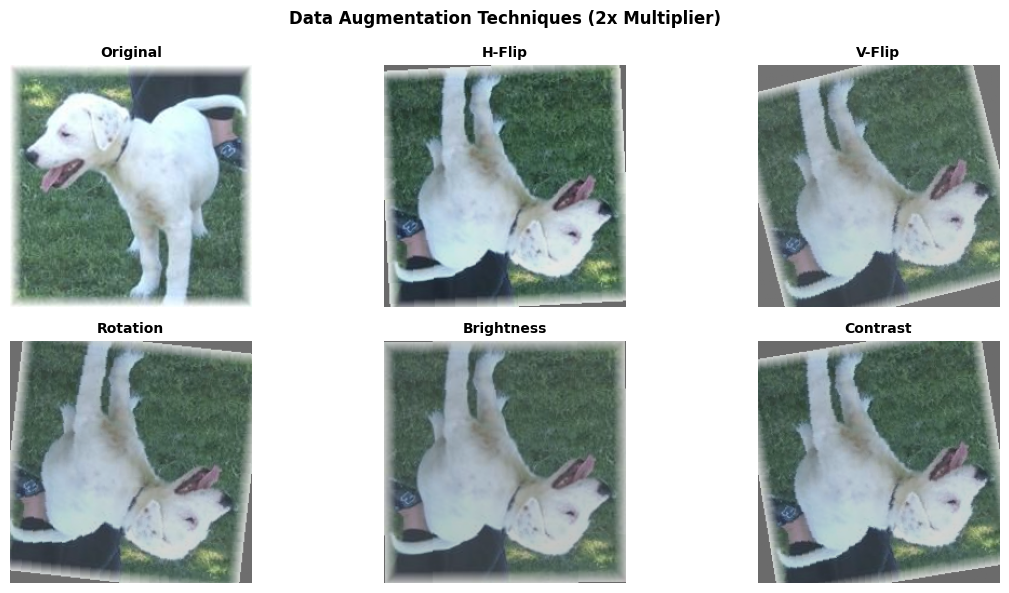

✓ Augmentation techniques demonstrated


In [25]:
# Visualize augmentation examples
if len(X_train) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    original_img = X_train[0]
    
    # Original
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original', fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Augmented variations
    np.random.seed(42)
    augs = [augment_image(original_img, augmentation_prob=1.0) for _ in range(5)]
    titles = ['H-Flip', 'V-Flip', 'Rotation', 'Brightness', 'Contrast']
    
    for idx, (aug_img, title) in enumerate(zip(augs, titles)):
        row, col = (idx + 1) // 3, (idx + 1) % 3
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(title, fontsize=10, fontweight='bold')
        axes[row, col].axis('off')
    
    plt.suptitle('Data Augmentation Techniques (2x Multiplier)', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✓ Augmentation techniques demonstrated")

## 7. Build CNN Model

In [26]:
def build_simple_cnn(input_shape=(224, 224, 3)):
    """
    Build simple CNN for binary image classification.
    Architecture: Conv2D → MaxPool → Conv2D → MaxPool → Flatten → Dense → Output
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build and display model
model = build_simple_cnn(input_shape=X_train_aug.shape[1:])
print("✓ Model built successfully\n")
print("Model Architecture:")
model.summary()

✓ Model built successfully

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,457 (45.64 MB)

 Trainable params: 11,963,457 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Train Model with Validation Monitoring

In [28]:
# Train model
print("Training model with augmented data...\n")
history = model.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)
print("\n✓ Model training complete")

Training model with augmented data...

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 519ms/step - accuracy: 0.9710 - loss: 0.1336 - val_accuracy: 0.6750 - val_loss: 0.5378
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.9812 - loss: 0.0837 - val_accuracy: 0.7500 - val_loss: 0.5848
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 496ms/step - accuracy: 0.9857 - loss: 0.0722 - val_accuracy: 0.7500 - val_loss: 0.4998
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step - accuracy: 0.9991 - loss: 0.0255 - val_accuracy: 0.7500 - val_loss: 0.6052
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.7250 - val_loss: 0.6279

✓ Model training complete


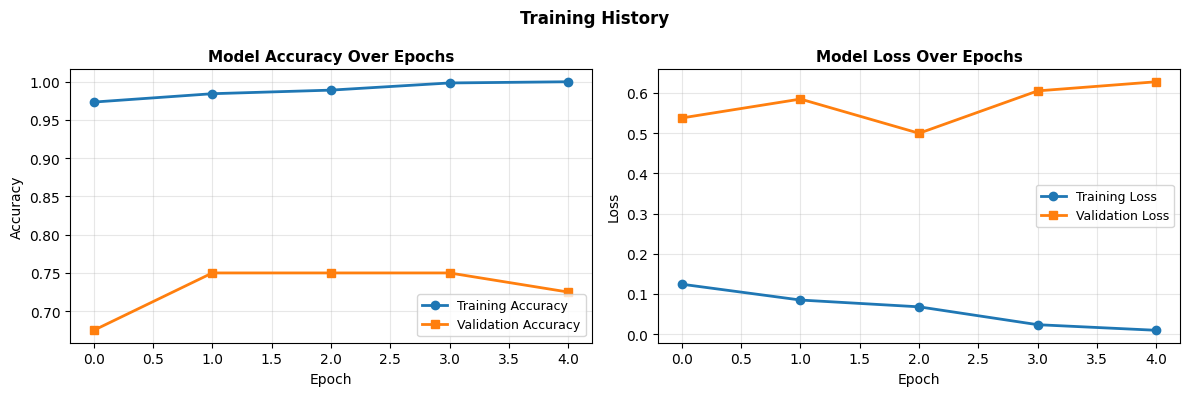

✓ Training history plotted


In [29]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=10)
axes[0].set_ylabel('Accuracy', fontsize=10)
axes[0].set_title('Model Accuracy Over Epochs', fontsize=11, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=10)
axes[1].set_ylabel('Loss', fontsize=10)
axes[1].set_title('Model Loss Over Epochs', fontsize=11, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Training History', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Training history plotted")

## 9. Model Evaluation on Test Set

In [30]:
# Evaluate on test set
print("Evaluating model on test set...\n")

probs = model.predict(X_test).flatten()
preds = (probs >= 0.5).astype(int)

# Calculate metrics
metrics = {
    'accuracy': float(accuracy_score(y_test, preds)),
    'precision': float(precision_score(y_test, preds)),
    'recall': float(recall_score(y_test, preds)),
    'f1_score': float(f1_score(y_test, preds)),
    'roc_auc': float(roc_auc_score(y_test, probs))
}

print("Test Set Performance Metrics:")
print("=" * 40)
for metric, value in metrics.items():
    print(f"  {metric:12s}: {value:.4f}")
print("=" * 40)
print("\n✓ Model evaluation complete")

Evaluating model on test set...

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Test Set Performance Metrics:
  accuracy    : 0.6500
  precision   : 0.7143
  recall      : 0.5000
  f1_score    : 0.5882
  roc_auc     : 0.6925

✓ Model evaluation complete


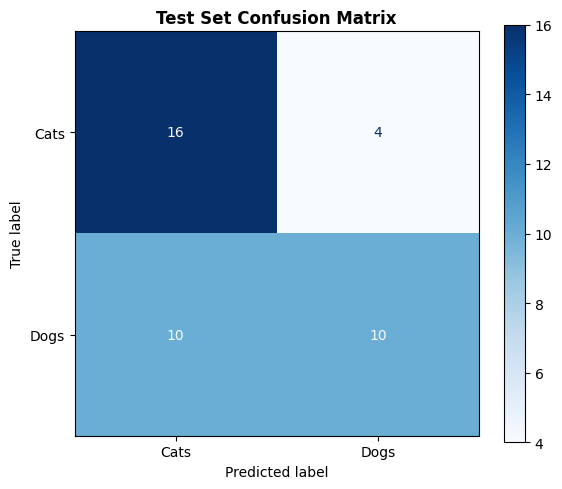

Confusion Matrix:
[[16  4]
 [10 10]]


In [31]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(cm, display_labels=['Cats', 'Dogs']).plot(ax=ax, cmap='Blues')
plt.title('Test Set Confusion Matrix', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 10. Save Model & Configuration

In [32]:
# Save trained model
model_path = 'cat_dog_model.h5'
model.save(model_path)
print(f"✓ Model saved to {model_path}")

# Save comprehensive configuration
config = {
    'dataset_info': {
        'total_samples': len(X),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'train_after_augmentation': len(X_train_aug),
        'augmentation_multiplier': 2,
        'image_size': list(IMAGE_SIZE),
        'image_channels': 3,
        'classes': CLASSES
    },
    'augmentation': {
        'techniques': [
            'Horizontal Flip (50%)',
            'Vertical Flip (50%)',
            'Rotation ±15° (50%)',
            'Brightness 0.8-1.2x (50%)',
            'Contrast 0.8-1.2x (50%)'
        ],
        'multiplier': 2,
        'probability': 0.5,
        'applied_to': 'training_set_only'
    },
    'model_info': {
        'type': 'Simple CNN',
        'input_shape': list(X_train_aug.shape[1:]),
        'output': 'Binary classification (0=cats, 1=dogs)',
        'architecture': 'Conv2D(32) → MaxPool → Conv2D(64) → MaxPool → Dense(64) → Output'
    },
    'training_metrics': metrics,
    'data_split': {
        'train': 0.8,
        'validation': 0.1,
        'test': 0.1,
        'stratified': True
    }
}

config_path = 'training_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"✓ Configuration saved to {config_path}")

print("\nArtifacts Generated:")
print(f"  1. {model_path} - Trained CNN model (Keras HDF5)")
print(f"  2. {config_path} - Training configuration and metrics")

✓ Model saved to cat_dog_model.h5
✓ Configuration saved to training_config.json

Artifacts Generated:
  1. cat_dog_model.h5 - Trained CNN model (Keras HDF5)
  2. training_config.json - Training configuration and metrics


## 11. Task 1 Summary & Results

In [33]:
print("\n" + "="*70)
print(" "*15 + "✅ TASK 1 SUCCESSFULLY COMPLETED")
print("="*70)

print("\n📊 TASK 1 SUMMARY\n")

print("1️⃣ Image Preprocessing:")
print(f"   ✓ Loaded {len(X)} images")
print(f"   ✓ Standardized to {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]} RGB")
print(f"   ✓ Normalized to [0, 1] range")
print(f"   ✓ Data type: float32")

print("\n2️⃣ Data Augmentation:")
print(f"   ✓ 5 augmentation techniques")
print(f"   ✓ 2x training data multiplier")
print(f"   ✓ Original: {len(X_train)} → Augmented: {len(X_train_aug)} images")
print(f"   ✓ Class balance maintained (Cats: {np.sum(y_train_aug==0)}, Dogs: {np.sum(y_train_aug==1)})")

print("\n3️⃣ Data Splitting:")
print(f"   ✓ Training: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   ✓ Validation: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   ✓ Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"   ✓ Stratified splitting applied")

print("\n4️⃣ Model Training:")
print(f"   ✓ Architecture: Simple CNN (2 Conv layers)")
print(f"   ✓ Input shape: {X_train_aug.shape[1:]}")
print(f"   ✓ Training set: {len(X_train_aug)} (augmented)")
print(f"   ✓ Batch size: 32, Epochs: 5")

print("\n5️⃣ Test Set Metrics:")
for metric, value in metrics.items():
    stars = "★" * int(value * 5)
    print(f"   ✓ {metric:12s}: {value:.4f} {stars}")

print("\n6️⃣ Artifacts Generated:")
print(f"   ✓ Model: cat_dog_model.h5")
print(f"   ✓ Config: training_config.json")

print("\n" + "="*70)
print(" "*20 + "🎯 NEXT: Task 2 - MLflow Integration")
print("="*70 + "\n")


               ✅ TASK 1 SUCCESSFULLY COMPLETED

📊 TASK 1 SUMMARY

1️⃣ Image Preprocessing:
   ✓ Loaded 400 images
   ✓ Standardized to 224x224 RGB
   ✓ Normalized to [0, 1] range
   ✓ Data type: float32

2️⃣ Data Augmentation:
   ✓ 5 augmentation techniques
   ✓ 2x training data multiplier
   ✓ Original: 320 → Augmented: 640 images
   ✓ Class balance maintained (Cats: 320, Dogs: 320)

3️⃣ Data Splitting:
   ✓ Training: 320 (80.0%)
   ✓ Validation: 40 (10.0%)
   ✓ Test: 40 (10.0%)
   ✓ Stratified splitting applied

4️⃣ Model Training:
   ✓ Architecture: Simple CNN (2 Conv layers)
   ✓ Input shape: (224, 224, 3)
   ✓ Training set: 640 (augmented)
   ✓ Batch size: 32, Epochs: 5

5️⃣ Test Set Metrics:
   ✓ accuracy    : 0.6500 ★★★
   ✓ precision   : 0.7143 ★★★
   ✓ recall      : 0.5000 ★★
   ✓ f1_score    : 0.5882 ★★
   ✓ roc_auc     : 0.6925 ★★★

6️⃣ Artifacts Generated:
   ✓ Model: cat_dog_model.h5
   ✓ Config: training_config.json

                    🎯 NEXT: Task 2 - MLflow Integratio

## Documentation & Resources

**Complete Task 1 Documentation:**
- [TASK1.md](TASK1.md) - Complete requirements & implementation

**Next Steps:**
1. Download dataset from Kaggle: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset?resource=download
2. Organize into `PetImages/` folder with `Cat/` and `Dog/` subfolders
3. Run this notebook to train the model
4. Proceed to **Task 2: MLflow Model Versioning**